In [1]:
%matplotlib inline

Interactive analysis with python
--------------------------------

Before starting this tutorial, ensure that you have set up _tangos_ [as described here](../README.md) and the data sources [as described here](data_exploration.md).

We get started by importing the modules we'll need:

In [4]:
%matplotlib inline
import tangos
import pylab as p

First let's inspect what simulations are available in our database:

In [5]:
tangos.all_simulations()

[<Simulation("tutorial_ramses")>,
 <Simulation("tutorial_gadget")>,
 <Simulation("tutorial_changa")>]

For any of these simulations, we can generate a list of available timesteps as follows:

In [6]:
tangos.get_simulation("tutorial_changa").timesteps

[<TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000384' z=4.57 t=1.31 Gyr>,
 <TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000448' z=4.03 t=1.53 Gyr>,
 <TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000640' z=2.96 t=2.17 Gyr>,
 <TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000832' z=2.32 t=2.82 Gyr>,
 <TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000960' z=2.02 t=3.25 Gyr>]

For any timestep, we can access the halos using `.halos` and a specific halo using standard python 0-based indexing:

In [8]:
tangos.get_simulation("tutorial_changa").timesteps[3].halos[3]

<Halo 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000832/halo_4' | NDM=199525 Nstar=7531 Ngas=19920>

One can skip straight to getting a specific halo as follows:

In [9]:
tangos.get_halo("tutorial_changa/%384/halo_4")

<Halo 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000384/halo_4' | NDM=87599 Nstar=1900 Ngas=9220>

Note the use of the SQL wildcard % character which avoids us having to type out the entire path. Whatever way you access it, the resulting object allows you to query what properties have been calculated for that specific halo. We can then access those properties using the normal python square-bracket dictionary syntax.

In [11]:
halo = tangos.get_halo("tutorial_changa/%960/halo_1")
halo.keys()

['Mvir',
 'Rvir',
 'contamination_fraction',
 'shrink_center',
 'max_radius',
 'dm_density_profile',
 'dm_mass_profile',
 'gas_density_profile',
 'gas_mass_profile',
 'star_density_profile',
 'star_mass_profile',
 'gas_map_sideon',
 'uvi_image_sideon',
 'gas_map_faceon',
 'uvi_image_faceon',
 'gas_map',
 'uvi_image',
 'ptcls_in_common',
 'ptcls_in_common',
 'ptcls_in_common',
 'ptcls_in_common']

In [13]:
halo['Mvir']

637727000000.0

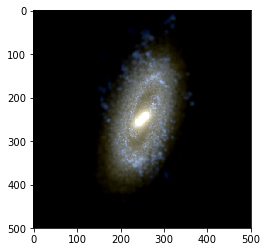

In [27]:
p.imshow(halo['uvi_image'])

Getting a time sequence of properties
-------------------------------------

Often we would like to see how a property varies over time. _Tangos_ provides convenient ways to extract this information, automatically finding 
major progenitors or descendants for a halo. Let's see this illustrated on the SubFind _mass_ property:

[]

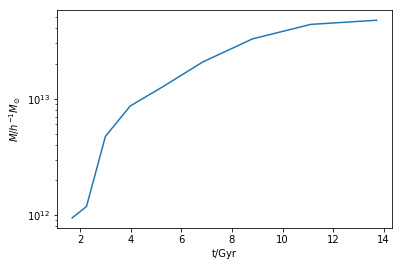

In [45]:
halo = tangos.get_halo("tutorial_gadget/snapshot_020/halo_10")

# Calculate on major progenitor branch:
Mvir, t = halo.calculate_for_progenitors("mass","t()")

# Now perform plotting:
p.plot(t,1e10*Mvir)
p.xlabel("t/Gyr")
p.ylabel(r"$M/h^{-1} M_{\odot}$")
p.semilogy()

In the example above, `calculate_for_progenitors` retrieves properties on the major progenitor branch of the chosen halo. One can ask for as many properties as you like, each one being returned as a numpy array in order. In this particular example the first property is the mass (as reported by subfind) and the second is the time. In fact the second property isn't really stored - if you check `halo.keys()` you won't find `t` in there. It's a simple example of a _live property_ which means it's calculated on-the-fly from other data. The time is actually stored in the TimeStep rather than the Halo database entry, so the `t()` live property simply retrieves it from the appropriate location.

Live properties are a powerful aspect of _tangos_. We'll see more of them momentarily.

Getting properties for multiple halos
-------------------------------------

Quite often one wants to collect properties from multiple halos simultaneously. Suppose we want to plot the mass against the vmax for all halos at
a specific snapshot:

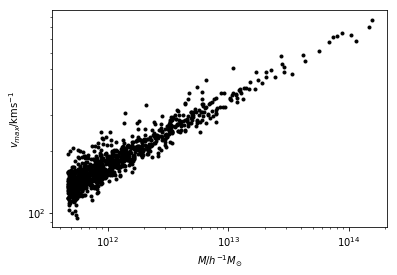

In [63]:
timestep = tangos.get_timestep("tutorial_gadget/snapshot_019")
mass, vmax = timestep.calculate_all("mass","VMax")

p.plot(mass*1e10,vmax,'k.')
p.loglog()
p.xlabel("$M/h^{-1} M_{\odot}$")
p.ylabel(r"$v_{max}/{\rm km s^{-1}}$")

Often when querying multiple halos we still want to know something about their history, and live calculations enable that. Suppose we want to know how much the mass has grown since the previous snapshot:

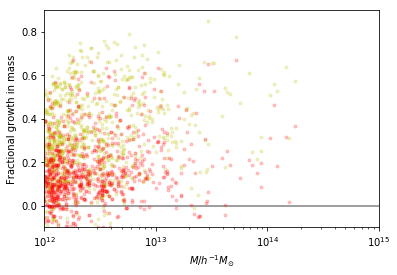

In [67]:
mass, fractional_delta_1, fractional_delta_2 = timestep.calculate_all("mass", "(mass-earlier(1).mass)/mass", "(mass-earlier(2).mass)/mass")

p.hlines(0.0,1e10,1e15, colors="gray")
p.plot(mass*1e10, fractional_delta_2,"y.", alpha=0.2)
p.plot(mass*1e10, fractional_delta_1,"r.", alpha=0.2)
p.semilogx()
p.ylim(-0.1,0.9)
p.xlim(1e12,1e15)
p.xlabel("$M/h^{-1} M_{\odot}$")
p.ylabel("Fractional growth in mass")

This is a much more ambitious use of the live calculation system. Consider the last property retrieved, which is `(mass-earlier(2).mass)/mass`. This combines algebraic operations with _redirection_: `earlier(2)` finds the major progenitor two steps prior to this one, after which `.mass` retrieves the mass at that earlier timestep.

For more information see the [live calculation](live_calculation.md) page.